In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
subset_size = 5000  # Use only 5000 images
trainset_small = torch.utils.data.Subset(trainset, range(subset_size))
testset_small = torch.utils.data.Subset(testset, range(subset_size // 2))

trainloader = torch.utils.data.DataLoader(trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset_small, batch_size=32, shuffle=False)

In [7]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s]


In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 3  # Reduce epochs for speed
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 1/3 - Train Loss: 1.3572, Train Acc: 53.14%, Test Loss: 1.7317, Test Acc: 52.48%
Epoch 2/3 - Train Loss: 0.9210, Train Acc: 68.32%, Test Loss: 1.1239, Test Acc: 64.56%
Epoch 3/3 - Train Loss: 0.7168, Train Acc: 76.08%, Test Loss: 0.8219, Test Acc: 71.88%


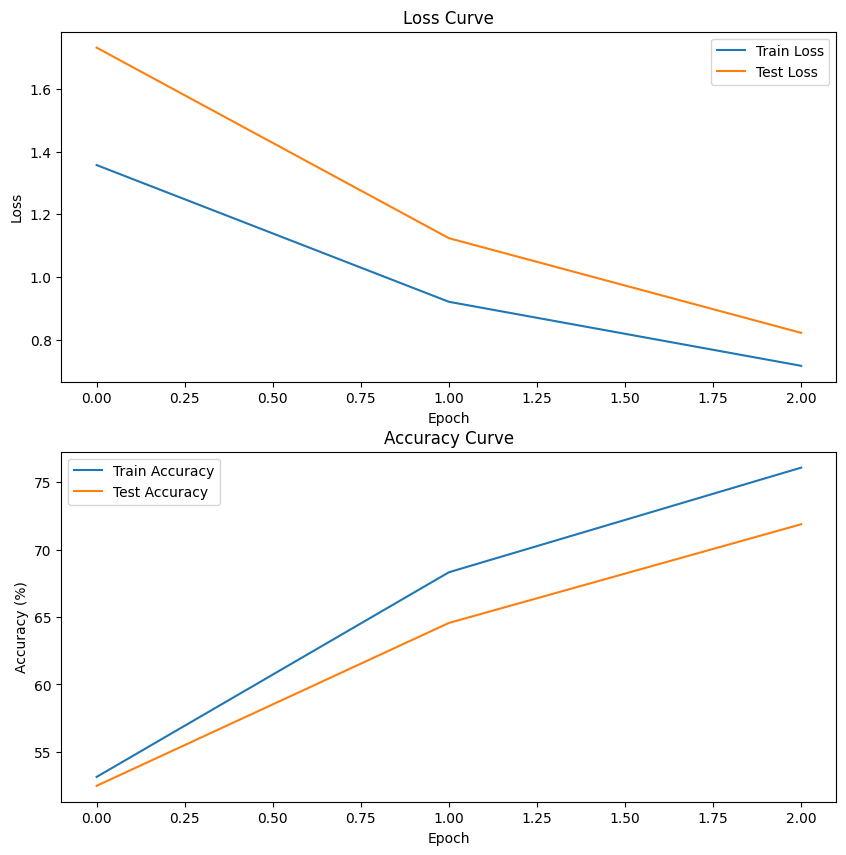

In [12]:
# Plot training results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Loss curve
axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(test_losses, label="Test Loss")
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Accuracy curve
axs[1].plot(train_accuracies, label="Train Accuracy")
axs[1].plot(test_accuracies, label="Test Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.show()

 Here's a concise summary of what I did:

1. **Loaded the CIFAR-10 dataset** and applied transformations to resize images to **224x224** (to match ResNet34's input size) and normalize them.
2. **Used a pretrained ResNet34 model** and modified the **fully connected layer** (`fc`) to output **10 classes instead of 1000** (since CIFAR-10 has 10 categories). This is the **fine-tuning step**.
3. **Trained the model** using **Adam optimizer** and **CrossEntropyLoss**, with a **smaller subset of data (5000 images)** to reduce memory usage.
4. **Evaluated the model** on a test set and tracked **loss and accuracy**.
5. **Plotted the loss and accuracy curves** to visualize model performance.


Analysis of the Results:
Loss Curve Analysis:

Both train loss and test loss are decreasing, which means the model is learning effectively.
The test loss is consistently higher than the train loss, which is normal, but if the gap grows too large, it could indicate overfitting.
Accuracy Curve Analysis:

Both train accuracy and test accuracy are increasing steadily, meaning the model is improving in classification.
The test accuracy is slightly lower than the train accuracy, which is expected.
The accuracy is around 75% for training and 70% for testing, which is good considering only 3 epochs and a small dataset.